## Jupyter notebook to generate data for figures.

Figures should be plotted in a separate Jupyter notebook

### For generating data of percentage of significant peaks in file 1330_0 between RT 2400-2700

In [168]:
import json
import math
import os
from copy import copy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyopenms as pms

BASE_DIR = Path().resolve().parent
TSV_DIR = BASE_DIR / "data" / "tsv"
MZML_DIR = BASE_DIR / "data" / "mzml"
MZML_MAPPED_TSV_DIR = TSV_DIR / "mapped_mzml_to_osw_qval_01_mz_window_20ppm"
FIG_DATA_DIR = BASE_DIR / "presentation" / "data"


In [400]:
# Get MZML experiment object

mzml_filepath = (
    MZML_DIR
    / "Rost_DIApy3_SP2um_90min_250ngK562_100nL_1_Slot1-5_1_1330_6-28-2021_0_2400_to_2700_swath_700.mzML"
)


def get_msexperiment_obj(mzml_filepath):
    # Read corresponding mzML file and load it into pyopenms object
    msexperiment = pms.MSExperiment()
    pms.MzMLFile().load(str(mzml_filepath), msexperiment)
    return msexperiment


exps = get_msexperiment_obj(mzml_filepath)


In [337]:
# Path to significant QVALUE OSW datapath
sig_qvalue_osw = TSV_DIR / "20220127_run_1330_0_sig_qval_null_feature_ftrans_trans_score_ms2.tsv"
# Path to one of the 168 MZML experiments - isolated significant peaks
mzml_exp = MZML_MAPPED_TSV_DIR / "merged_20220127_frame=22786_scan=452_qvalue_01.tsv"


In [338]:
# Load significant QVALUE OSW dataframe
sig_qvalue_osw_df = pd.read_csv(sig_qvalue_osw, sep="\t").drop(columns=["FEATURE_ID"])
# Load significant MZML experiment
mzml_exp_df = pd.read_csv(mzml_exp, sep="\t")
# Merge loaded df on col TRANSITION_ID
merged_mzml_osw_df = mzml_exp_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")


In [406]:
# Generate IM range for filtering - +/- 0.05
im_range = 0.05
merged_mzml_osw_df["EXP_IM_LEFT"] = merged_mzml_osw_df["EXP_IM"] - im_range
merged_mzml_osw_df["EXP_IM_RIGHT"] = merged_mzml_osw_df["EXP_IM"] + im_range


In [340]:
# Define function to gather percentage significant peaks in various settings such as:
# - % peaks found in a significant file compared to MZML object
# - % peaks found using RT range in a significant file compared to MZML object
# - % peaks found using RT and IM range in a significant file compared to MZML object

from collections import Counter


def get_perc_peaks_found_in_mzml(reduced_df, reduced_df_filename, merged_df, mzml_exps):
    def round_(x):
        """For floating point conversion - nearly impossible to do comparison otherwise."""
        return str(x)[:8]

    # Get experiment ID from filename
    exp_name_tsv = "frame" + str(reduced_df_filename).split("frame")[-1].split("_qvalue")[0]
    # Iterate through MZML experiments and match with filename.
    for mz_idx, exp in enumerate(mzml_exps):
        if exp_name_tsv == exp.getNativeID():
            # If filename match, extract attributes from MZML experiment
            mz, int_ = exp.get_peaks()
            rt = exp.getRT()
            im = exp.getFloatDataArrays()[0].get_data()[mz_idx]
            peak_count = map(round_, mz)
            break
    # Create counter for peak counts.
    peak_count_map = dict(Counter(peak_count))

    # Find just sig MZ from isolated dataframe
    found_mz_peaks = set(map(round_, reduced_df["MZ"]))
    count = 0
    for peak in found_mz_peaks:
        count += peak_count_map[peak]
    # % peaks found in a significant file compared to MZML object
    mz_perc = count / len(mz)

    # Find sig MZ in RT window
    rt_window_df = merged_df[(merged_df["LEFT_WIDTH"] < rt) & (merged_df["RIGHT_WIDTH"] > rt)]
    found_mz_rt_peaks = set(map(round_, rt_window_df["MZ"]))
    count = 0
    for peak in found_mz_rt_peaks:
        count += peak_count_map[peak]
    # % peaks found using RT range in a significant file compared to MZML object
    mz_rt_perc = count / len(mz)

    # Find sig MZ in RT window AND in IM window
    rt_im_window_df = rt_window_df[
        (rt_window_df["EXP_IM_LEFT"] < im) & (rt_window_df["EXP_IM_RIGHT"] > im)
    ]
    found_mz_rt_im_peaks = set(map(round_, rt_im_window_df["MZ"]))
    count = 0
    for peak in found_mz_rt_im_peaks:
        count += peak_count_map[peak]
    # % peaks found using RT and IM range in a significant file compared to MZML object
    mz_rt_im_perc = count / len(mz)

    # Return MZ percentage, MZ-RT percentage, MZ-RT-IM percentage, and experiment ID
    return mz_perc, mz_rt_perc, mz_rt_im_perc, exp.getNativeID()


# Test logic
perc = get_perc_peaks_found_in_mzml(mzml_exp_df, mzml_exp, merged_mzml_osw_df, exps)
perc


(0.7641719472512416,
 0.2586915567734201,
 0.05125021407775304,
 'frame=22786_scan=452')

In [26]:
# Iterate through content of significant files dir (total 168 TSV files) and pipe files to
# perc sig peak calculator.

mzml_perc_list = []
im_range = 0.05

for filepath in os.listdir(MZML_MAPPED_TSV_DIR):
    if filepath.endswith(".tsv"):
        filepath = MZML_MAPPED_TSV_DIR / filepath
        # Load significant MZML TSV file.
        mz_df = pd.read_csv(filepath, sep="\t")

        # Merged MZML/OSW DF has to be generated every time.
        merged_mzml_osw_df = mz_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")
        merged_mzml_osw_df["EXP_IM_LEFT"] = merged_mzml_osw_df["EXP_IM"] - im_range
        merged_mzml_osw_df["EXP_IM_RIGHT"] = merged_mzml_osw_df["EXP_IM"] + im_range

        mz_perc, mz_rt_perc, mz_rt_im_perc, exp_id = get_perc_peaks_found_in_mzml(
            mz_df, filepath, merged_mzml_osw_df, exps
        )
        print(mz_perc, mz_rt_perc, mz_rt_im_perc, exp_id)

        mzml_perc_list.append(tuple([mz_perc, mz_rt_perc, mz_rt_im_perc, exp_id]))


In [ ]:
# Get all percentage features and RT - sort by RT


def get_exp_rt_from_frame_id(exps, frame_id):
    # Get additional attributes from MZML experiment
    for exp in exps:
        if exp.getNativeID() == frame_id:
            return exp.getRT()


# Generate summary percentage array for export as JSON (1 cell down)
summary = []
for run in mzml_perc_list:
    frame_id = run[-1]
    run = list(run)
    # Append experiment RT value
    run.append(get_exp_rt_from_frame_id(exps, frame_id))
    summary.append(run)

# Sort by experiment RT value
summary = sorted(summary, key=lambda x: x[-1])
# Unpack value for testing
# mz_perc, mz_rt_perc, mz_rt_im_perc, exp_id, exp_rt = zip(*summary)


In [ ]:
# Export `mzml_perc_list` as JSON for figure building

cumulative_json = []
for item in summary:
    export_json = {
        "rt": "",
        "exp_id": "",
        "mz_perc_identified": "",
        "mz_perc_rt_identified": "",
        "mz_perc_rt_im_identified": "",
    }
    export_json["rt"] = item[-1]
    export_json["exp_id"] = item[-2]
    export_json["mz_perc_identified"] = item[0]
    export_json["mz_perc_rt_identified"] = item[1]
    export_json["mz_perc_rt_im_identified"] = item[2]
    cumulative_json.append(export_json)

# Export cumulated JSON to file
with open(FIG_DATA_DIR / "20220131_perc_peaks_identified_1330_0.json", "w") as f:
    json.dump(cumulative_json, f)


### For generating data to compare insignificant peaks vs significant peaks

In [44]:
all_qvalue_osw = TSV_DIR / "20220127_qval_null_feature_ftrans_trans_score_ms2.tsv"
nonsig_qvalue_osw = TSV_DIR / "20220127_nonsig_qval_null_feature_ftrans_trans_score_ms2.tsv"

In [42]:
def read_chunk_tsv(input_path, chunksize=1_000_000):
    # DON'T USE IF YOU ARE PLANNING TO MERGE TABLES ON A KEY
    print(f"Reading {input_path} as TSV chunk")
    with pd.read_csv(input_path, sep="\t", chunksize=chunksize) as reader:
        yield from reader
        
def export_as_tsv(df, output_path):
    print("Exporting dataframe as TSV...")
    df.to_csv(output_path, sep="\t", index=False)


In [41]:
all_qvalue_osw_df = read_chunk_tsv(all_qvalue_osw)
nonsig_qvalue_osw_df = pd.DataFrame()

## Completed on 2021-01-31 - don't run again.
# for idx, chunk in enumerate(all_qvalue_osw_df):
#     print(f"Reading chunk #{idx + 1} with shape {chunk.shape}.", end="\r")
#     nonsig_qvalue_osw_df = pd.concat([nonsig_qvalue_osw_df, chunk[chunk["QVALUE"] >= 0.01]])

Reading /Users/irahorecka/Desktop/Harddrive_Desktop/PhD/University of Toronto/Rotations/Rost Lab/roest-ms/data/tsv/20220127_qval_null_feature_ftrans_trans_score_ms2.tsv as TSV chunk


In [45]:
# Export nonsignificant peaks found in OSW file - delete when project is complete...
export_as_tsv(nonsig_qvalue_osw_df, nonsig_qvalue_osw)

Exporting dataframe as TSV...


In [407]:
# Finding cumulative intensities for peaks that were found in MZML file
# Define function to gather percentage significant peaks in various settings such as:
# - % peaks found in a significant file compared to MZML object
# - % peaks found using RT range in a significant file compared to MZML object
# - % peaks found using RT and IM range in a significant file compared to MZML object

from collections import Counter


def get_mz_int_peaks_nonfound_in_mzml(reduced_df, reduced_df_filename, merged_df, mzml_exps, include_rt=False, include_rt_im=False):
    def round_(x):
        """For floating point conversion - nearly impossible to do comparison otherwise."""
        return str(x)[:8]

    # Get experiment ID from filename
    exp_name_tsv = "frame" + str(reduced_df_filename).split("frame")[-1].split("_qvalue")[0]
    # Iterate through MZML experiments and match with filename.
    for mz_idx, exp in enumerate(mzml_exps):
        if exp_name_tsv == exp.getNativeID():
            # If filename match, extract attributes from MZML experiment
            mz, int_ = exp.get_peaks()
            rt = exp.getRT()
            im = exp.getFloatDataArrays()[0].get_data()[mz_idx]
            peak_count = map(round_, mz)
            break

    found_mz_peaks = dict(Counter(set(map(round_, reduced_df["MZ"]))))
    
    if include_rt is True or include_rt_im is True:
        ## Filter intensity between left and right RT window
        rt_window_df = merged_df[(merged_df["LEFT_WIDTH"] < rt) & (merged_df["RIGHT_WIDTH"] > rt)]
        found_mz_peaks = dict(Counter(set(map(round_, rt_window_df["MZ"]))))
    
    if include_rt_im is True:
        ## Filter intensity between left and right window
        rt_im_window_df = rt_window_df[
            (rt_window_df["EXP_IM_LEFT"] < im) & (rt_window_df["EXP_IM_RIGHT"] > im)
        ]
        found_mz_peaks = dict(Counter(set(map(round_, rt_im_window_df["MZ"]))))
    
    found_mz = []
    nonfound_mz = []
    found_int = []
    nonfound_int = []
    count = 0
    
    for idx, peak in enumerate(peak_count):
        try:
            found_mz_peaks[peak]
            found_mz.append(mz[idx])
            found_int.append(int_[idx])
        except KeyError:
            count += 1
            nonfound_mz.append(mz[idx])
            nonfound_int.append(int_[idx])
    print("NonFound peak perc:", count / len(mz))
    print("Found peak perc:", 1 - count / len(mz))
    return found_mz, found_int, nonfound_mz, nonfound_int, exp.getNativeID()


mzml_exp = MZML_MAPPED_TSV_DIR / "merged_20220127_frame=24707_scan=452_qvalue_01.tsv"
mzml_exp_df = pd.read_csv(mzml_exp, sep="\t")
# Test logic
perc = get_mz_int_peaks_nonfound_in_mzml(mzml_exp_df, mzml_exp, merged_mzml_osw_df, exps, include_rt_im=True)
found_mz, found_int, nonfound_mz, nonfound_int, exp_id = perc

NonFound peak perc: 0.876930767308173
Found peak perc: 0.12306923269182701


In [395]:
def get_10_150_rt_data(rt_arr):
    return [rt for rt in rt_arr if rt < 150 and rt > 11]

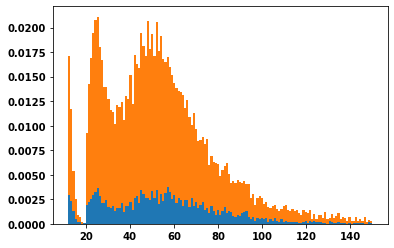

In [396]:
found_int_10_150 = list(map(str, get_10_150_rt_data(found_int)))
nonfound_int_10_150 = list(map(str, get_10_150_rt_data(nonfound_int)))

export_json = {
    "found_intensity_perc_range_10_150": found_int_10_150,
    "nonfound_intensity_perc_range_10_150": nonfound_int_10_150,
}

# Change filename as you fiddle with binning of peaks (e.g. MZ, MZ-RT, etc...)
# with open(FIG_DATA_DIR / "20220131_MZ_RT_IM_perc_intensity_found_nonfound_1330_0.json", "w") as f:
#     json.dump(export_json, f)
    

# Demo purposes
found_int_10_150 = get_10_150_rt_data(found_int)
nonfound_int_10_150 = get_10_150_rt_data(nonfound_int)
plt.hist([nonfound_int_10_150, found_int_10_150], stacked=True, density=True, bins=139)
plt.show()

In [397]:
def yield_perc_int_window_found(found_int, nonfound_int):
    joined_int = found_int + nonfound_int
    prev_perc_found = 0
    for i in range(math.ceil(max(joined_int)) + 1):
        range_found_int = []
        for int_ in found_int:
            if int_ > i-1 and int_ <= i:
                range_found_int.append(int_)

        range_nonfound_int = []
        for int_ in nonfound_int:
            if int_ > i-1 and int_ <= i:
                range_nonfound_int.append(int_)
        
        try:
            perc_found = len(range_found_int) / (len(range_found_int) + len(range_nonfound_int))
            prev_perc_found = copy(perc_found)
            yield (i, perc_found)
        except ZeroDivisionError:
            # Previous iteration's perc_found
            yield (i, prev_perc_found)

In [398]:
rt_window = []
perc_found_in_rt_window = []
for idx, item in yield_perc_int_window_found(found_int_10_150, nonfound_int_10_150):
    if item != 0:
        rt_window.append(idx)
        perc_found_in_rt_window.append(item)
        
export_json = {
    "intensity_window_range_10_150": rt_window,
    "perc_found_intensity_range_10_150": perc_found_in_rt_window,
}

# Change filename as you fiddle with binning of peaks (e.g. MZ, MZ-RT, etc...)
# with open(FIG_DATA_DIR / "20220131_int_window_MZ_RT_IM_perc_intensity_found_nonfound_1330_0.json", "w") as f:
#     json.dump(export_json, f)
    

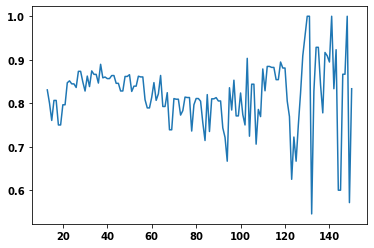

In [399]:
plt.plot(rt_window, perc_found_in_rt_window)
plt.show()

In [408]:
# Set up all data again for analysis
# Generate IM range for filtering - +/- 0.05
merged_mzml_osw_df = mzml_exp_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")

im_range = 0.05
merged_mzml_osw_df["EXP_IM_LEFT"] = merged_mzml_osw_df["EXP_IM"] - im_range
merged_mzml_osw_df["EXP_IM_RIGHT"] = merged_mzml_osw_df["EXP_IM"] + im_range


In [440]:
# Now, find the most significant RT window and use this data for export
def get_found_nonfound(mzml_exp_path, merged_mzml_osw_df, **kwargs):
    mzml_exp_df = pd.read_csv(mzml_exp_path, sep="\t")
    merged_mzml_osw_df = mzml_exp_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")
    im_range = 0.05
    merged_mzml_osw_df["EXP_IM_LEFT"] = merged_mzml_osw_df["EXP_IM"] - im_range
    merged_mzml_osw_df["EXP_IM_RIGHT"] = merged_mzml_osw_df["EXP_IM"] + im_range

    found_mz, found_int, nonfound_mz, nonfound_int, exp_id = get_mz_int_peaks_nonfound_in_mzml(mzml_exp_df, mzml_exp_path, merged_mzml_osw_df, exps, **kwargs)

    # Bin intensity range between 10 and 150
    found_int_10_150 = get_10_150_rt_data(found_int)
    nonfound_int_10_150 = get_10_150_rt_data(nonfound_int)
    
    return found_int_10_150, nonfound_int_10_150


def export_rt_intensity_dist(mzml_exp_path, merged_mzml_osw_df, out_json_path, **kwargs):
    found_int_10_150, nonfound_int_10_150 = get_found_nonfound(mzml_exp_path, merged_mzml_osw_df, **kwargs)
    found_int_10_150 = list(map(str, found_int_10_150))
    nonfound_int_10_150 = list(map(str, nonfound_int_10_150))
    export_json = {
        "found_intensity_perc_range_10_150": found_int_10_150,
        "nonfound_intensity_perc_range_10_150": nonfound_int_10_150,
    }
    # Change filename as you fiddle with binning of peaks (e.g. MZ, MZ-RT, etc...)
    with open(FIG_DATA_DIR / out_json_path, "w") as f:
        json.dump(export_json, f)
        

def export_rt_intensity_window(mzml_exp_path, merged_mzml_osw_df, out_json_path, **kwargs):
    found_int_10_150, nonfound_int_10_150 = get_found_nonfound(mzml_exp_path, merged_mzml_osw_df, **kwargs)
    rt_window = []
    perc_found_in_rt_window = []
    for idx, item in yield_perc_int_window_found(found_int_10_150, nonfound_int_10_150):
        if item != 0:
            rt_window.append(idx)
            perc_found_in_rt_window.append(item)

    export_json = {
        "intensity_window_range_10_150": rt_window,
        "perc_found_intensity_range_10_150": perc_found_in_rt_window,
    }

    # Change filename as you fiddle with binning of peaks (e.g. MZ, MZ-RT, etc...)
    with open(FIG_DATA_DIR / out_json_path, "w") as f:
        json.dump(export_json, f)



mzml_exp = MZML_MAPPED_TSV_DIR / "merged_20220128_frame=25523_scan=452_qvalue_01.tsv"
# export_rt_intensity_dist(mzml_exp, merged_mzml_osw_df, '20220131_RT_2688.630046_frame=25523_scan=452_MZ_RT_IM_intensity.json', include_rt_im=True)
export_rt_intensity_window(mzml_exp, merged_mzml_osw_df, '20220131_RT_2688.630046_frame=25523_scan=452_MZ_RT_IM_intensity_window.json', include_rt_im=True)

NonFound peak perc: 0.8457459746071898
Found peak perc: 0.1542540253928102


## Explorative code

All programs posted here are for exploratory purposes. If significant, tidy and move above section.

### Look at all intensity histograms tracking found/non-found for 168 RT sections (experiments) in MZML file

In [391]:
# For explorative purposes...
def open_json(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)
    return data

sig_peak_json = FIG_DATA_DIR / "perc_peaks_identified_1330_0.json"
data = open_json(sig_peak_json)

exp_rt, exp_id, mz_perc, mz_rt_perc, mz_rt_im_perc = zip(*[d.values() for d in data])
data[0]

{'rt': 2400.240718,
 'exp_id': 'frame=22786_scan=452',
 'mz_perc_identified': 0.7641719472512416,
 'mz_perc_rt_identified': 0.2586915567734201,
 'mz_perc_rt_im_identified': 0.05125021407775304}

In [392]:
def hist_plot_found_nonfound(found, non_found, rt, bins):
    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.hist([non_found, found], label=['Non-found', 'Found'], stacked=True, density=True, bins=bins)
    plt.title(f'Intensity distribution of found & non-found peaks - RT: {rt}')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Density")
    plt.ylim((0,0.04))
    plt.xlim((0,150))
    plt.savefig(f"hist_sample{rt}.png", dpi=100)
    # plt.show()

In [393]:
# Iteratively produce plots - histograms - check for diff

def run_multi_hist(sig_qvalue_osw_df):
    # data reffed above
    for idx, item in enumerate(data):
        for filepath in os.listdir(MZML_MAPPED_TSV_DIR):
            if item['exp_id'] in filepath:
                break
        
        filepath = MZML_MAPPED_TSV_DIR / filepath
        # Load significant MZML TSV file.
        mz_df = pd.read_csv(filepath, sep="\t")

        # Merged MZML/OSW DF has to be generated every time.
        merged_mzml_osw_df = mz_df.merge(sig_qvalue_osw_df, on="TRANSITION_ID")
        merged_mzml_osw_df["EXP_IM_LEFT"] = merged_mzml_osw_df["EXP_IM"] - im_range
        merged_mzml_osw_df["EXP_IM_RIGHT"] = merged_mzml_osw_df["EXP_IM"] + im_range

        found_mz, found_int, nonfound_mz, nonfound_int, exp_id = get_mz_int_peaks_nonfound_in_mzml(mz_df, filepath, merged_mzml_osw_df, exps)

        found_int_10_150 = list(map(str, get_10_150_rt_data(found_int)))
        nonfound_int_10_150 = list(map(str, get_10_150_rt_data(nonfound_int)))

        # Demo purposes
        found_int_10_150 = get_10_150_rt_data(found_int)
        nonfound_int_10_150 = get_10_150_rt_data(nonfound_int)

        # Get bin length
        found_bin = len(sorted(set(list(map(round, found_int_10_150)))))
        nonfound_bin = len(sorted(set(list(map(round, nonfound_int_10_150)))))

        if found_bin > nonfound_bin:
            bins = found_bin + 1
        else:
            bins = nonfound_bin + 1
        print(bins)
    
        print('Plotting:', item['rt'], 'with featureID:', exp_id)
        hist_plot_found_nonfound(found_int_10_150, nonfound_int_10_150, item['rt'], bins)

run_multi_hist(sig_qvalue_osw_df)